Simple GPT model written from scratch and trained in a corpus of Shakespeare text.

### Tokenizer

In [1]:
import re
class BPE_regex:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges_map = dict()
        self.vocabulary = {idx: bytes([idx]) for idx in range(256)}
        self.pat = r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| \d+| ?[^\s\w\d]+|\s+(?!\S)|\s+" # contractions, words, numbers, punctuation, continued spaces except 
        # the last space so it doesn't destroy the structure where a word or number starts with a space, and finally continued spaces at the end of the string 

    def decode(self, encoded):
        # Join the bytes as a string of bytes and then decode
        return b''.join([self.vocabulary[idx] for idx in encoded]).decode('utf-8', errors='replace')
    
    def encode(self, text):
        tokens = []
        for token in re.findall(self.pat, text, re.IGNORECASE):
            tokens.extend(tokenizer._encode(token))
        return tokens
    
    def _encode(self, text):
        # Transform string to a list of bytes
        encoded = list(text.encode('utf-8'))

        while len(encoded) > 1:
            # Find the pair that should be merged first: It is the pair that has the lowest id in the vocabulary
            pairs = set()
            for pair in zip(encoded[:-1], encoded[1:]):
                pairs.add(pair)
            pair_to_merge = min(pairs, key=lambda pair: self.merges_map.get(pair, float('inf'))) # The pair with the lowest index

            # If there is no pair to merge break out of the loop
            if pair_to_merge not in self.merges_map:
                break

            # Replace each merged token one by one in the merged order
            new_tokens = []
            i = 0
            while i < len(encoded):
                pair = encoded[i], encoded[i+1] if i < len(encoded) -1 else None # if is the last position pair is None
                # If there is pair to merge add the proper id and advance i to skip the tail of the pair
                if pair is not None and pair == pair_to_merge:
                    new_tokens.append(self.merges_map[pair_to_merge])
                    i += 1
                # If there is no pair to merge, add the id i in the ith position
                else:
                    new_tokens.append(encoded[i])
                # Go to the next id
                i += 1
            encoded = new_tokens

        return encoded

    def train(self, corpus):
        pre_tokens = re.findall(self.pat, corpus, re.IGNORECASE)
        new_encoded = [list(tok.encode('utf-8')) for tok in pre_tokens]

        vocab_size = 256 # initial vocab_size is the number of bytes
        while vocab_size < self.vocab_size:
            # Count pairs
            counts = {}
            for fragment in new_encoded:
                for pair in zip(fragment[:-1], fragment[1:]):
                    counts[pair] = counts.get(pair, 0) + 1
            # Get the pair to create the new token
            max_pair = max(counts, key=counts.get)

            # Save the new token
            new_tok_id = vocab_size
            self.vocabulary[new_tok_id] = self.vocabulary[max_pair[0]] + self.vocabulary[max_pair[1]] # Concatenate the bytes
            self.merges_map[max_pair] = new_tok_id
            vocab_size += 1

            # Check if there is any merging to do
            new_tokens = []
            for fragment in new_encoded:
                fragment_tokens = []
                i = 0
                while i < len(fragment):
                    pair = fragment[i], fragment[i+1] if i < len(fragment) -1 else None # if is the last position pair is None
                    if pair is not None and pair == max_pair:
                        fragment_tokens.append(new_tok_id)
                        i += 1
                    else:
                        fragment_tokens.append(fragment[i])
                    i += 1
                new_tokens.append(fragment_tokens)
            new_encoded = new_tokens


with open('shakespeare.txt') as file:
    corpus = file.read()
tokenizer = BPE_regex(2000)
tokenizer.train(corpus)

In [2]:
tokenizer.decode(tokenizer.encode(corpus)) == corpus

True

In [3]:
tokenizer.vocabulary

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

block_size = 256
emb_dim = 384
batch_size = 64
head_dim = 384
blocks_num = 6
heads_num = 6
droput = 0.4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
# Create the dataset
stoi = {s:i for i,s in tokenizer.vocabulary.items()}
print(len(tokenizer.vocabulary))

tokenized = torch.tensor(tokenizer.encode(corpus))
n = int(0.9*len(tokenized))
train_data = tokenized[:n]
val_data = tokenized[n:]
print(len(train_data), len(val_data))

2000
351411 39046


In [22]:
# Visualize the tokenization
[tokenizer.vocabulary[idx.item()] for idx in train_data[:100]]

[b'First',
 b' Citizen',
 b':',
 b'\n',
 b'Be',
 b'fore',
 b' we',
 b' pro',
 b'ceed',
 b' any',
 b' fur',
 b'ther',
 b',',
 b' hear',
 b' me',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'Sp',
 b'eak',
 b',',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'You',
 b' are',
 b' all',
 b' res',
 b'ol',
 b'ved',
 b' rather',
 b' to',
 b' die',
 b' than',
 b' to',
 b' f',
 b'am',
 b'ish',
 b'?',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'R',
 b'es',
 b'ol',
 b'ved',
 b'.',
 b' res',
 b'ol',
 b'ved',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'First',
 b',',
 b' you',
 b' know',
 b' C',
 b'a',
 b'ius',
 b' Marcius',
 b' is',
 b' chi',
 b'ef',
 b' enemy',
 b' to',
 b' the',
 b' people',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'We',
 b' know',
 b"'t",
 b',',
 b' we',
 b' know',
 b"'t",
 b'.',
 b'\n',
 b'\n',
 b'First']

In [7]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) # For every letter, the target is the letter to the right
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

x, y = get_batch('train')
x.shape, y.shape # Check how for each data element (64 features) there are 64 targets. Thats is because self-attention generates an output for each position (this can be used to make the prediction of the next token)

(torch.Size([64, 256]), torch.Size([64, 256]))

In [8]:
# Examples:
for i in range(8):
    print(f'\n\nEXAMPLE {i+1}:')
    for j in range(x.shape[1]):
        print(f'{tokenizer.decode(x[i,:j+1].cpu().numpy())} -> {tokenizer.decode([y[i,j].item()])}')



EXAMPLE 1:
 p -> ick
 pick ->  my
 pick my ->  l
 pick my l -> ance
 pick my lance -> .
 pick my lance. -> 

 pick my lance.
 -> 

 pick my lance.

 -> MENENIUS
 pick my lance.

MENENIUS -> :
 pick my lance.

MENENIUS: -> 

 pick my lance.

MENENIUS:
 -> Nay
 pick my lance.

MENENIUS:
Nay -> ,
 pick my lance.

MENENIUS:
Nay, ->  these
 pick my lance.

MENENIUS:
Nay, these ->  are
 pick my lance.

MENENIUS:
Nay, these are ->  al
 pick my lance.

MENENIUS:
Nay, these are al -> m
 pick my lance.

MENENIUS:
Nay, these are alm -> ost
 pick my lance.

MENENIUS:
Nay, these are almost ->  th
 pick my lance.

MENENIUS:
Nay, these are almost th -> or
 pick my lance.

MENENIUS:
Nay, these are almost thor -> ough
 pick my lance.

MENENIUS:
Nay, these are almost thorough -> ly
 pick my lance.

MENENIUS:
Nay, these are almost thoroughly ->  pers
 pick my lance.

MENENIUS:
Nay, these are almost thoroughly pers -> u
 pick my lance.

MENENIUS:
Nay, these are almost thoroughly persu -> ad
 pick my lan

In [23]:
class Head(nn.Module):
    def __init__(self,inp_dim, h_dim, block_size):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wk = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wv = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.tril = torch.tril(torch.ones(block_size, block_size, device=device))

        self.dropout = nn.Dropout(droput)

    def forward(self, x):
        B, T, C = x.shape
        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv
        attention = Q @ K.transpose(-2, -1) # [B,T,C]@[B,C,T] = [B,T,T]
        attention *= Q.shape[-1]**-0.5
        masked_attention = attention.masked_fill(self.tril[:T,:T] == 0, -torch.inf) # Mask future tokens. The [:T,:T] is to be able to work with inputs of less than T tokens, this is helpful for generation
        att_weights = F.softmax(masked_attention, dim=2) # Regularize the weights
        att_weights = self.dropout(att_weights)
        return att_weights @ V # [B,T,T]@[B,T,C] = [B,T,C] Make a weighted average of the vectors the possition attends to

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_dim, head_dim//num_heads, block_size) for _ in range(num_heads)])
        self.linear = nn.Linear(head_dim, input_dim)

        self.droput = nn.Dropout(droput)

    def forward(self, x):
        att = torch.cat([h(x) for h in self.heads], dim=-1)
        att = self.linear(att)
        att = self.droput(att)
        return att
    
class Block(nn.Module):
    def __init__(self, num_heads, emb_dim, block_size):
        super().__init__()
        self.selfAttention = MultiHeadAttention(emb_dim, num_heads, block_size)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ffd = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim), # scale up
            nn.ReLU(),
            nn.Linear(4*emb_dim, emb_dim), # scale down again for compatibility with the residual connections
            nn.Dropout(droput)
        )
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        att = self.selfAttention(x)
        att = self.ln1(att + x)
        x = self.ffd(x)
        x = self.ln2(att + x)
        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(len(tokenizer.vocabulary), emb_dim)
        self.pos_emb = nn.Embedding(block_size, emb_dim)

        self.blocks = nn.Sequential(*[Block(heads_num, emb_dim, block_size) for _ in range(blocks_num)]) # Without the * it breaks

        self.final_dropout = nn.Dropout(droput)

        self.final_proj = nn.Linear(head_dim, len(tokenizer.vocabulary))

    def forward(self, x, targets=None):
        emb1 = self.token_emb(x)
        # print(emb1.shape)
        emb2 = self.pos_emb(torch.arange(emb1.shape[1], device=device)) # Use emb.shape[1] instead of block_size because of inference. To being able to generate a prediction starting from 1 token with a max of block_size
        # print(emb2.shape)
        emb = emb1 + emb2
        # print(emb.shape)
        x = self.blocks(emb)

        x = self.final_dropout(x)
        # print(att.shape)
        logits = self.final_proj(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(batch_size*block_size, -1), targets.view(batch_size*block_size))
        return logits, loss

In [24]:
@torch.no_grad
def estimate_loss():
    model.eval()
    samples = 10
    # Estimate train loss
    losses = []
    for i in range(samples):
        x, y = get_batch('train')
        _, loss = model(x, y)
        losses.append(loss)
    train_loss = sum(losses)/samples
    print(f'Train loss: {train_loss:.2f}', end='\t')
    # Estimate Validation loss
    losses = []
    for i in range(samples):
        x, y = get_batch('valid')
        _, loss = model(x, y)
        losses.append(loss)
    val_loss = sum(losses)/samples
    print(f'Val loss: {val_loss:.2f}')
    model.train()
    return train_loss, val_loss

In [25]:
import math

steps = 10000
learning_rate = 3e-4
train_lossi = []
val_lossi = []

model = GPTModel()
model.train()
model = model.to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Baseline loss
print('baseline loss', -math.log(1/len(tokenizer.vocabulary)))

for i in range(steps):
    x, y = get_batch('train')
    logits, loss = model(x, y)
    if i % 500 == 0:
        train_loss, val_loss = estimate_loss()
    
    # Update the weights
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Track stats
    train_lossi.append(train_loss)
    val_lossi.append(val_loss)

12.276176 M parameters
baseline loss 7.600902459542082
Train loss: 7.74	Val loss: 7.74
Train loss: 4.11	Val loss: 4.42
Train loss: 3.70	Val loss: 4.17
Train loss: 3.42	Val loss: 4.04
Train loss: 3.16	Val loss: 4.01
Train loss: 2.95	Val loss: 3.93
Train loss: 2.78	Val loss: 3.98
Train loss: 2.62	Val loss: 4.02
Train loss: 2.46	Val loss: 4.01
Train loss: 2.31	Val loss: 4.15
Train loss: 2.17	Val loss: 4.22
Train loss: 2.02	Val loss: 4.22
Train loss: 1.91	Val loss: 4.28
Train loss: 1.78	Val loss: 4.39
Train loss: 1.67	Val loss: 4.50
Train loss: 1.56	Val loss: 4.51
Train loss: 1.47	Val loss: 4.61
Train loss: 1.39	Val loss: 4.62
Train loss: 1.32	Val loss: 4.73
Train loss: 1.26	Val loss: 4.76


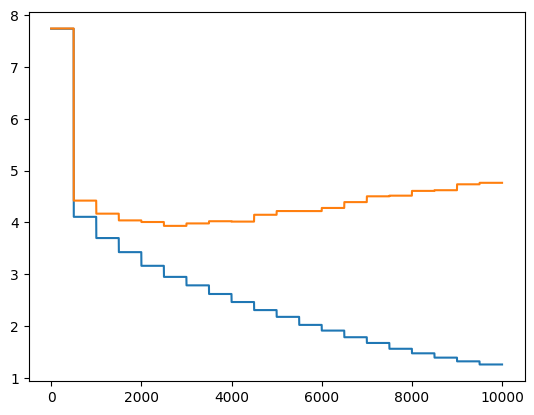

In [32]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(train_lossi))
plt.plot(torch.tensor(val_lossi))

In [27]:
# Generation
model.eval()
@torch.no_grad
def generate(max_tokens=500):
    sample = torch.tensor([tokenizer.encode('\n')], device=device)
    while sample.shape[-1] < max_tokens:
        logits, loss = model(sample[:,:block_size])
        logits = logits[:,-1,:]
        # print(logits.shape)
        probs = F.softmax(logits, dim=-1)
        next_tok = torch.multinomial(probs, 1)
        sample = torch.cat((sample, next_tok), dim=-1)
    return tokenizer.decode(sample[0].cpu().numpy())

print(generate())



RIVERS:
I now was for that; this new-made bridegroom!

GREY:
Delay, sweet prince, in this time,
Fear you the princes, whose corruption
Was door: and, ere the son,
Will you call'd it to the dark;
I do repent it, and I'll shortly.

BUCKINGHAM:
What was your grace, my lord?

GLOUCESTER:
To-morrow, what end you will?

BUCKINGHAM:
No; here comes the traitor's land?

BUCKINGHAM:
And, by your grace.

QUEEN ELIZABETH:
Of what odd! what occasion?

BUCKINGHAM:
What sudden, will it please you to 'head?

BUCKINGHAM:
There is no other way, my gracious lord?

BUCKINGHAM:
Withdraw your grace, those tender princely faults in,
And the most gracious sovereign,
Who hath the will of heaven that we have knowledge
To yield the ireful army, our law,
Who, the Lord Hastings, to of and,,, in, of of, of of of of, of of, and of of of and is of of, of, of of of of had of of of of,,,, of, of,,,, of of of of,, of of of of and and and,, of,,, of hath and,, of here, of of, of,, of of,, in and,, of,, and, of, of and 